In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [2]:
from merf import viz
from merf.merf import *
from sklearn import *
from statistics import mean
import plotly.express as px


In [3]:
import numpy as np
import pandas as pd
import seaborn as seas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import wbgapi as wb
from scipy import stats

seas.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [4]:
indexes = ['EN.ATM.CO2E.KT',        #CO2 emissions (kt)
           'NY.GDP.MKTP.PP.KD',     #GDP per capita, PPP (constant 2017 international $)
           'SP.POP.TOTL',           #Population, total 
           'EG.FEC.RNEW.ZS',        #Renewable energy consumption (% of total final energy
           'SP.URB.TOTL.IN.ZS',     #Urban population (% of total population) 
           'NV.MNF.TECH.ZS.UN',     #Medium and high-tech manufacturing value added (% manufacturing value added)
           'NE.TRD.GNFS.ZS']        #Trade (% of GDP)

In [5]:
countries = ['Argentina',
'Armenia',
'Australia',
'Austria',
'Belgium',
'Bulgaria',
'Belarus',
'Brazil',
'Canada',
'Switzerland',
'Chile',
'China',
'Colombia',
'Czech Republic',
'Germany',
'Denmark',
'Spain',
'Estonia',
'Finland',
'France',
'United Kingdom',
'Georgia',
'Greece',
'Croatia',
'Hungary',
'India',
'Ireland',
'Iceland',
'Israel',
'Italy',
'Japan',
'Kazakhstan',
'Korea, Rep.',
'Lithuania',
'Latvia',
'Moldova',
'Mexico',
'Malaysia',
'Netherlands',
'Norway',
'New Zealand',
'Panama',
'Peru',
'Poland',
'Portugal',
'Romania',
'Russian Federation',
'Singapore',
'Serbia',
'Slovak Republic',
'Slovenia',
'Sweden',
'Turkey',
'Ukraine',
'United States',
'South Africa'] 

In [6]:
countries = [wb.economy.coder(country) for country in countries]

In [7]:
raw_dataset = wb.data.DataFrame(series = indexes, economy = countries, time = range(1994,2023), labels=True,columns='series')

In [8]:
raw_dataset.unstack(0).stack()

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  \
time   economy                                                        
YR2021 ZAF       South Africa  2021             NaN             NaN   
       USA      United States  2021             NaN             NaN   
       UKR            Ukraine  2021             NaN             NaN   
       TUR            Turkiye  2021             NaN             NaN   
       SWE             Sweden  2021             NaN             NaN   
...                       ...   ...             ...             ...   
YR1994 BEL            Belgium  1994        0.939573        114900.0   
       AUT            Austria  1994       25.679455         58280.0   
       AUS          Australia  1994        8.259947        280180.0   
       ARM            Armenia  1994       17.763653          2740.0   
       ARG          Argentina  1994       10.734909        111910.0   

                NE.TRD.GNFS.ZS  NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD  \
time   economy                                                         
YR2021 ZAF           56.071227                NaN       7.881121e+11   
       USA                 NaN                NaN       2.093228e+13   
       UKR           82.621300                NaN       5.355789e+11   
       TUR           71.212724                NaN       2.657762e+12   
       SWE           88.162017                NaN       5.525622e+11   
...                        ...                ...                ...   
YR1994 BEL          113.232300          14.080100       3.740897e+11   
       AUT           65.987093          36.610757       3.129625e+11   
       AUS           36.458731          27.756124       5.726639e+11   
       ARM          112.429365          28.824233       9.053823e+09   
       ARG           18.134346          29.628354       6.224138e+11   

                SP.POP.TOTL  SP.URB.TOTL.IN.ZS  
time   economy                                  
YR2021 ZAF       60041996.0             67.847  
       USA      331893745.0             82.873  
       UKR       43814581.0             69.757  
       TUR       85042736.0             76.569  
       SWE       10415811.0             88.238  
...                     ...                ...  
YR1994 BEL       10115603.0             96.700  
       AUT        7936118.0             61.870  
       AUS       17855000.0             85.028  
       ARM        3283664.0             66.332  
       ARG       34402669.0             87.960  

[1568 rows x 9 columns]

# Overview

In [9]:
col = ['Number of variables',
'Number of observations',
'Missing cells',
'Missing cells (%)',
'Rows with Missing cells',
'Rows with Missing cells (%)',
'Duplicate rows',
'Duplicate rows (%)']

val = [len(raw_dataset.columns),
len(raw_dataset),
raw_dataset.isna().values.sum(),
(raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
len(raw_dataset) - len(raw_dataset.dropna()),
((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
raw_dataset.duplicated().sum(),
raw_dataset.duplicated().sum()]

val = list(map(round,val))

overview = pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

In [10]:
overview

Variables  Count
0          Number of variables      9
1       Number of observations   1568
2                Missing cells    362
3            Missing cells (%)     23
4      Rows with Missing cells    125
5  Rows with Missing cells (%)      8
6               Duplicate rows      0
7           Duplicate rows (%)      0

## Data preprocessing

### Renaming columns for berter readability

In [11]:
raw_dataset = raw_dataset.rename({'EG.FEC.RNEW.ZS': 'Renewable energy consumption',
'EN.ATM.CO2E.KT': 'CO2 emissions',
'NE.TRD.GNFS.ZS': 'Trade (% of GDP)',
'NV.MNF.TECH.ZS.UN': 'Perc Manufacturing Value Added',
'NY.GDP.MKTP.PP.KD': 'GDP per capita',
'SP.POP.TOTL': 'Total Population',
'SP.URB.TOTL.IN.ZS': 'Urban Population',
},axis = 1)

In [12]:
raw_dataset.head()

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2021  South Africa  2021                           NaN   
        YR2020  South Africa  2020                           NaN   
        YR2019  South Africa  2019                         10.50   
        YR2018  South Africa  2018                         10.19   
        YR2017  South Africa  2017                         10.45   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2021            NaN         56.071227   
        YR2020            NaN         51.126846   
        YR2019  439640.014648         54.150246   
        YR2018  434350.006104         54.507584   
        YR2017  435649.993896         53.535932   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2021                             NaN    7.881121e+11   
        YR2020                             NaN    7.511939e+11   
        YR2019                       24.428034    8.028319e+11   
        YR2018                       24.428034    8.019253e+11   
        YR2017                       24.428034    7.901706e+11   

                Total Population  Urban Population  
economy time                                        
ZAF     YR2021        60041996.0            67.847  
        YR2020        59308690.0            67.354  
        YR2019        58558267.0            66.856  
        YR2018        57792520.0            66.355  
        YR2017        57009751.0            65.850

### Missing value check


In [13]:
raw_dataset.isna().sum()

Country                             0
Time                                0
Renewable energy consumption      112
CO2 emissions                     112
Trade (% of GDP)                   14
Perc Manufacturing Value Added    112
GDP per capita                     12
Total Population                    0
Urban Population                    0
dtype: int64

In [14]:
raw_dataset = raw_dataset.dropna()

### Outlier detection and treatment

In [15]:
def outlier_treatment(dataset):
    """
    
    Values lying outside 3SD are considered as outliers for this analysis
    Outlier values are treated with mean of that column
    
    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    Dataframe with treated outlier values
    """
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset,outlier_summary

raw_dataset,outlier_summary = outlier_treatment(raw_dataset)

outlier_summary

Variables  No. of Outliers
0    Renewable energy consumption               14
1                   CO2 emissions               43
2                Trade (% of GDP)               27
3  Perc Manufacturing Value Added               10
4                  GDP per capita               38
5                Total Population               52
6                Urban Population               10

### Calculating Column of Intrest

In [16]:
raw_dataset['CO2 per Capita'] = raw_dataset['CO2 emissions']/raw_dataset['Total Population']

### Log Trasforming the data

In [17]:
for col in [col for col in raw_dataset.columns[2:]]:
    raw_dataset[col] = np.log10(raw_dataset[col] + 1)

In [18]:
processed_df = raw_dataset

In [19]:
# import tabloo

# tabloo.show(processed_df)

## Exploratory Data Analysis

### Data Summary


In [20]:
processed_df.describe(include='all')

Country  Time  Renewable energy consumption  CO2 emissions  \
count           1443  1443                   1443.000000    1443.000000   
unique            56    26                           NaN            NaN   
top     South Africa  2019                           NaN            NaN   
freq              26    56                           NaN            NaN   
mean             NaN   NaN                      1.115691       4.949772   
std              NaN   NaN                      0.391837       0.672622   
min              NaN   NaN                      0.123852       3.212454   
25%              NaN   NaN                      0.867761       4.583097   
50%              NaN   NaN                      1.148911       4.843239   
75%              NaN   NaN                      1.445530       5.525500   
max              NaN   NaN                      1.802568       6.580932   

        Trade (% of GDP)  Perc Manufacturing Value Added  GDP per capita  \
count        1443.000000                     1443.000000     1443.000000   
unique               NaN                             NaN             NaN   
top                  NaN                             NaN             NaN   
freq                 NaN                             NaN             NaN   
mean            1.863056                        1.509789       11.571755   
std             0.218728                        0.231886        0.640809   
min             1.158007                        0.690589        9.954466   
25%             1.733932                        1.405031       11.180345   
50%             1.866179                        1.569113       11.572287   
75%             2.014420                        1.674872       12.087101   
max             2.358700                        1.924619       12.960968   

        Total Population  Urban Population  CO2 per Capita  
count        1443.000000       1443.000000     1443.000000  
unique               NaN               NaN             NaN  
top                  NaN               NaN             NaN  
freq                 NaN               NaN             NaN  
mean            7.179238          1.853878        0.003108  
std             0.607142          0.090003        0.002062  
min             5.427273          1.475715        0.000323  
25%             6.721371          1.797787        0.001783  
50%             7.035915          1.872180        0.002858  
75%             7.675878          1.916499        0.003929  
max             8.516311          2.004321        0.020694

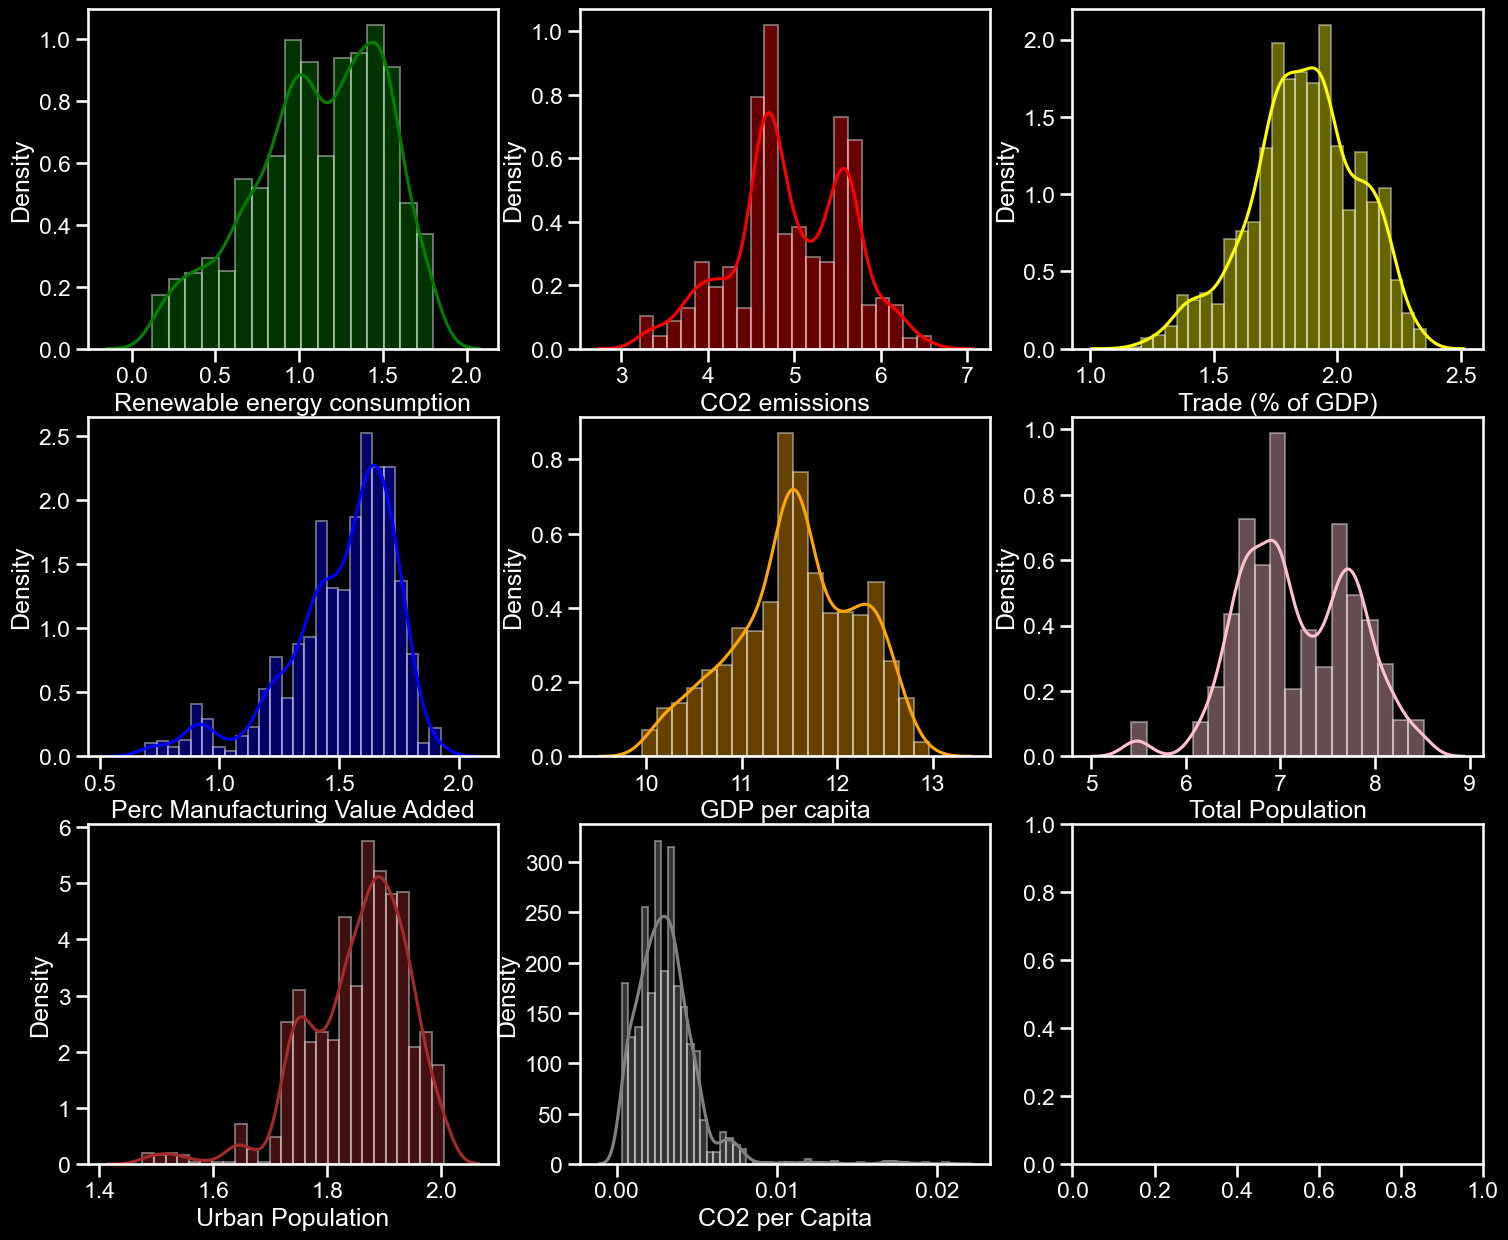

In [21]:
%matplotlib inline

n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[2:]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols])

### Pair Plots

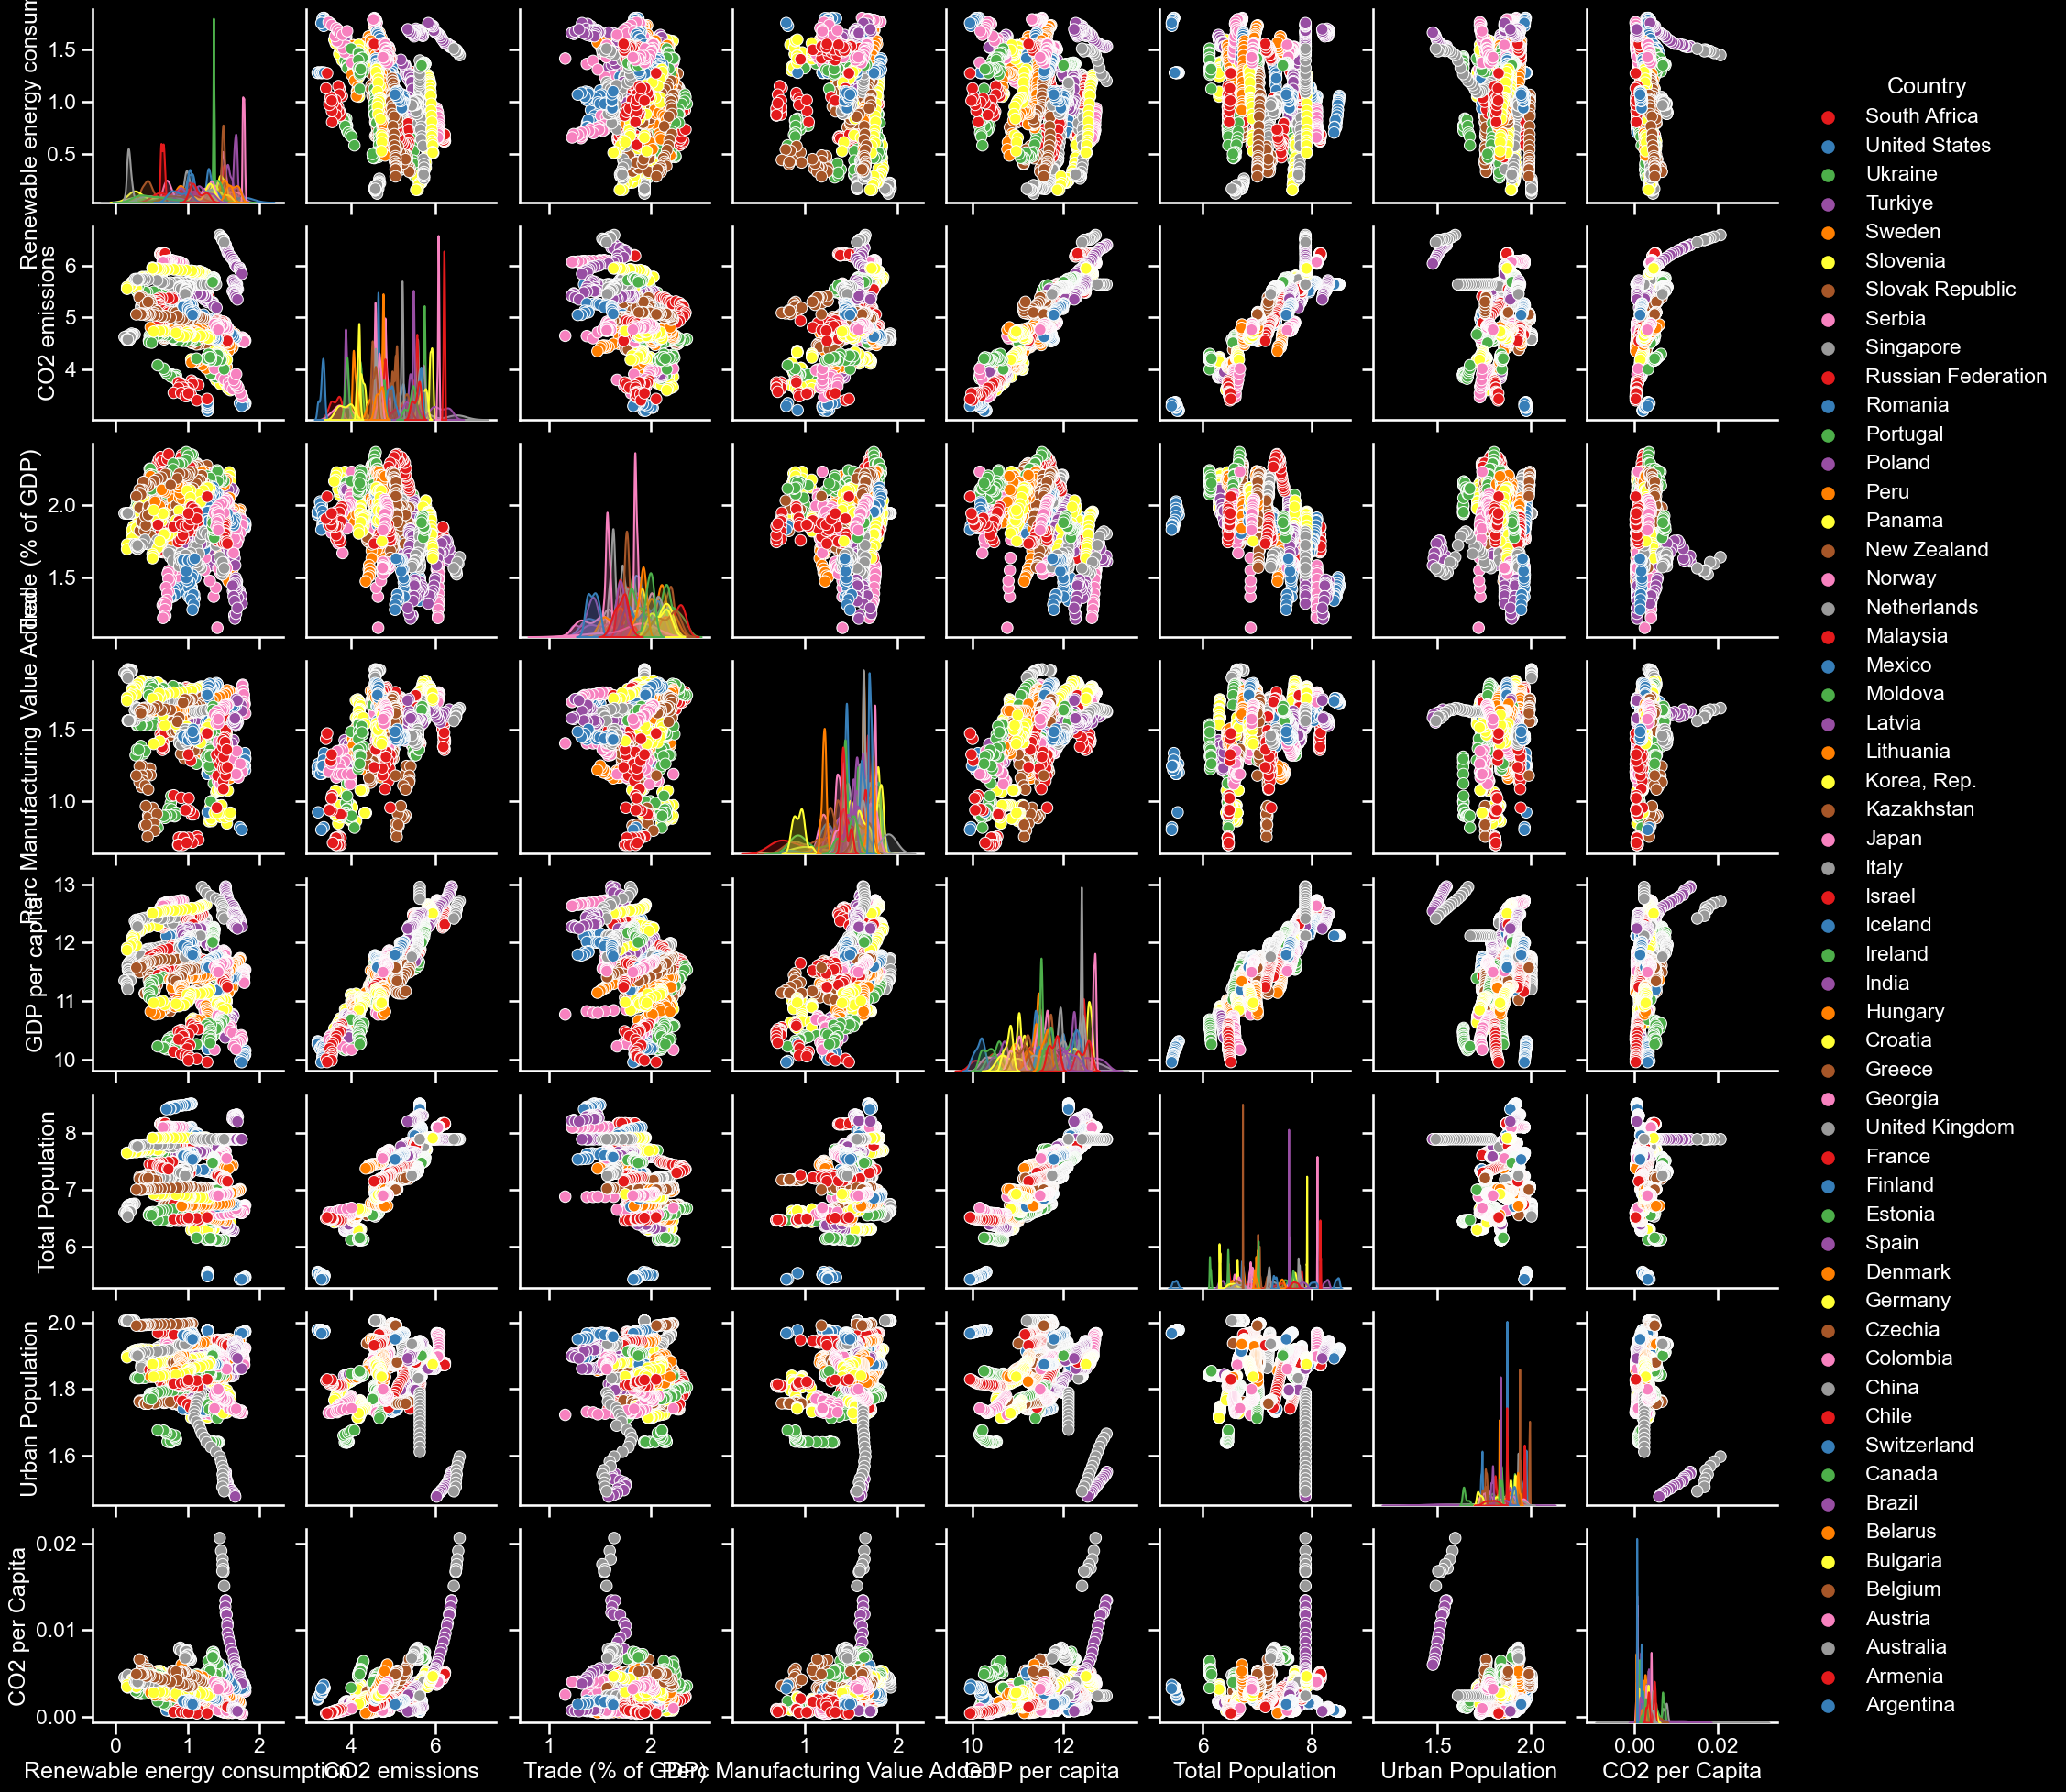

In [22]:

seas.pairplot(data=processed_df,  hue='Country',palette="Set1")


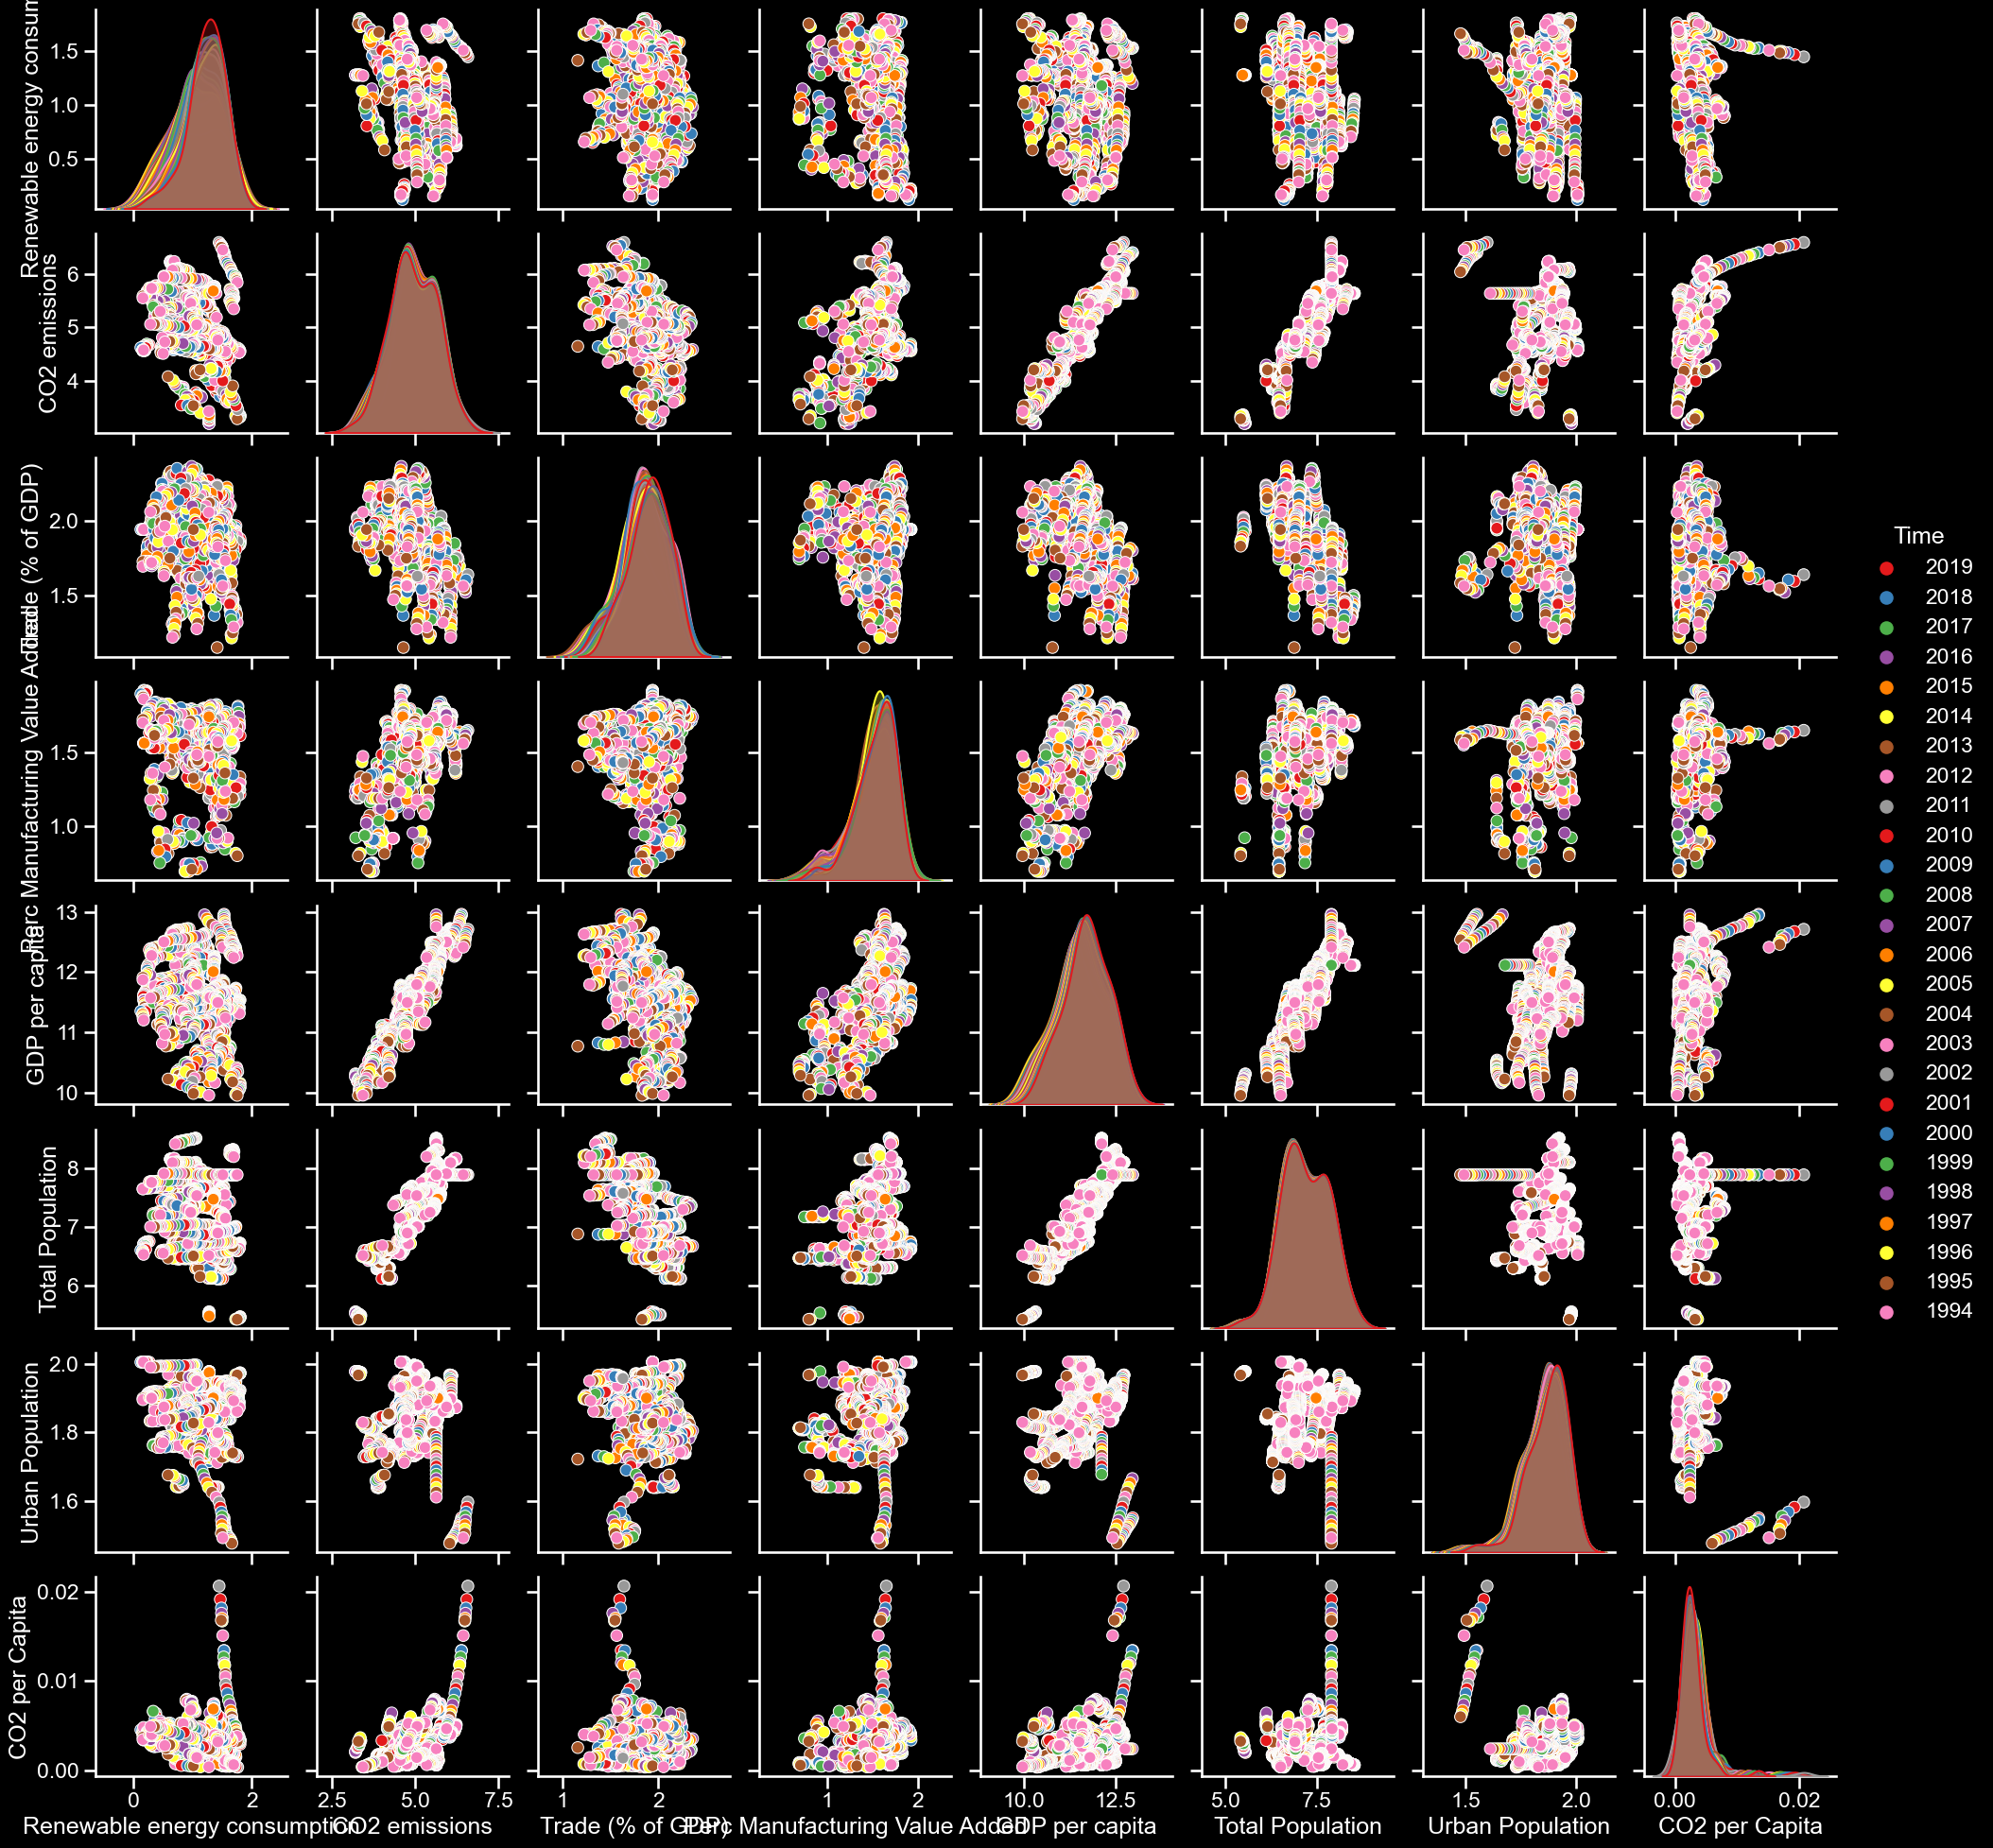

In [23]:
seas.pairplot(data=processed_df,  hue='Time',palette="Set1")


### Box Plots

In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

n_rows=3
n_cols=3

vars = ['Renewable energy consumption', 'CO2 emissions',
       'Trade (% of GDP)', 'Perc Manufacturing Value Added', 'GDP per capita',
       'Total Population', 'Urban Population', 'CO2 per Capita']

figsize = (18,15)

fig = make_subplots(rows=n_rows, cols=n_cols)

fig.update_layout(template="plotly_dark",width=1400,
    height=1000)

for i, var in enumerate(vars):
    
    fig.add_trace(
        go.Box(y=processed_df[var],
        name=var),
        row=(i//n_cols)+1, col=(i%n_cols)+1,
    )

fig.update_traces(boxpoints='all', jitter=.3)


## Modeling

## Data Spliting

In [25]:
X = processed_df[['Renewable energy consumption','Trade (% of GDP)','Perc Manufacturing Value Added','GDP per capita','Urban Population']]
y = processed_df['CO2 per Capita']
  
# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)


### Mixed Effects Random Forest model.  - `y=f(X)+biZ+e`

* y is the target variable. The current code only supports regression for now, e.g. continuously varying scalar value
* X is the fixed effect features. Assume p dimensional
* f(.) is the nonlinear fixed effects mode, e.g. random forest
* Z is the random effect features. Assume q dimensional.
* e is iid noise ~N(0, sigma_e²)
* i is the cluster index. Assume k clusters in the training.
* bi is the random effect coefficients. They are different per cluster i but are assumed to be drawn from the same distribution ~N(0, Sigma_b) where Sigma_b is learned from the data.

### MERF Package

**Parameters**

* X (np.ndarray) – fixed effect covariates
* Z (np.ndarray) – random effect covariates
* clusters (pd.Series) – cluster assignments for samples
* y (np.ndarray) – response/target variable

A lot of data out there has a clustered structure. The most typical example is longitudinal clustering, which occurs when there are many measurements per individual of a phenomenon to be modeled. Assume we wish to model math test scores as a function of sleep parameters, but each student has many measures. The unique student in this situation is a cluster. We employed the MERF model for this project to predict the CO2 per capita values, clustering the 56 countries we have.

## Hyperparameter Tuning

### We will use 2 techniques for hyperparameter tuning - Random Search and Gird Search. In grid search, we define the combinations and do training of the model, whereas in RandomizedSearchCV the model selects the combinations randomly.

In [26]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    mse = np.sqrt(np.sum((y_test - predictions)**2)) / len(y_test)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%.'.format(accuracy))
    print('Mean Squared Error: {:0.6f}'.format(np.mean(mse)))
    print('Mean Absolute Percentage Error (MAPE): {:0.2f}'.format(mape))

    return np.mean(errors), accuracy, mape, np.mean(mse)

### Random Forest (Base Model) 

In [27]:
base_rf_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_rf_model.fit(X_train, y_train)
base_rf_errors, base_rf_accuracy, base_rf_mape, base_rf_mse = evaluate(base_rf_model, X_test, y_test)

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 87.90%.
Mean Squared Error: 0.000030
Mean Absolute Percentage Error (MAPE): 12.10


### RandomizedSearchCV 

In [28]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # <- Number of trees in random forest
max_features = ['auto', 'sqrt'] # <- Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # <-  Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # <- Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # <- Minimum number of samples required at each leaf node
bootstrap = [True, False] # <- Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Combinations to try for Hyperparameter Tuning

In [29]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [30]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Random Search Best Parameters

#### Mean cross-validated score of the best estimator

In [31]:
print ('The best score is : {}%'.format(round(rf_random.best_score_*100.0, 2)))

The best score is : 91.03%


In [32]:
rf_random.best_params_


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

#### Best Random Search Model Evaluation

In [33]:
best_random = rf_random.best_estimator_
random_rf_errors,random_rf_accuracy,random_rf_mape,random_rf_mse = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 89.52%.
Mean Squared Error: 0.000025
Mean Absolute Percentage Error (MAPE): 10.48


### GridSearchCV

In [34]:
# Create the parameter grid based on the results of random search 
param_grid = {
      'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [600, 800, 1000, 1200, 1400]
    }

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)

In [35]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [80, 90, 100, 110, None],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [600, 800, 1000, 1200, 1400]},
             return_train_score=True, verbose=2)

### Gird Search Best Parameters

#### Mean cross-validated score of the best estimator

In [36]:
print ('The best score is : {}%'.format(round(grid_search.best_score_*100.0, 2)))

The best score is : 90.98%


In [37]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

#### Best Grid Search Model Evaluation

In [38]:
best_grid = grid_search.best_estimator_
grid_rf_errors,grid_rf_accuracy,grid_rf_mape,grid_rf_mse = evaluate(best_grid, X_test, y_test) 

Model Performance
Average Error: 0.0003 degrees.
Accuracy: 88.13%.
Mean Squared Error: 0.000027
Mean Absolute Percentage Error (MAPE): 11.87


# Mixed Effects Random Forest

## Predictor variable Random Effect

### Base Model

In [39]:
cv = KFold(n_splits=5, shuffle=True)
mse_base_re_mrf = []
mape_base_re_mrf = []
error_base_re_mrf = []
accuracy_base_re_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    base_re_mrf = MERF()
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    base_re_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = base_re_mrf.predict(X_test, Z_test, clusters_test)
    mse_base_re_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_base_re_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_base_re_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_base_re_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_base_re_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_base_re_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_base_re_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_base_re_mrf)))

INFO     [merf.py:307] Training GLL is -3504.2176699113875 at iteration 1.
INFO     [merf.py:307] Training GLL is -6263.136399225151 at iteration 2.
INFO     [merf.py:307] Training GLL is -8753.982724107973 at iteration 3.
INFO     [merf.py:307] Training GLL is -11121.671240553507 at iteration 4.
INFO     [merf.py:307] Training GLL is -13412.23612171824 at iteration 5.
INFO     [merf.py:307] Training GLL is -15624.683107432984 at iteration 6.
INFO     [merf.py:307] Training GLL is -17665.546197601518 at iteration 7.
INFO     [merf.py:307] Training GLL is -19230.491215004575 at iteration 8.
INFO     [merf.py:307] Training GLL is -20036.576183730565 at iteration 9.
INFO     [merf.py:307] Training GLL is -20353.057506794412 at iteration 10.
INFO     [merf.py:307] Training GLL is -20504.211684781163 at iteration 11.
INFO     [merf.py:307] Training GLL is -20595.01806715198 at iteration 12.
INFO     [merf.py:307] Training GLL is -20655.911056866204 at iteration 13.
INFO     [merf.py:307] Tr

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 93.87%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 6.13%


<AxesSubplot: >

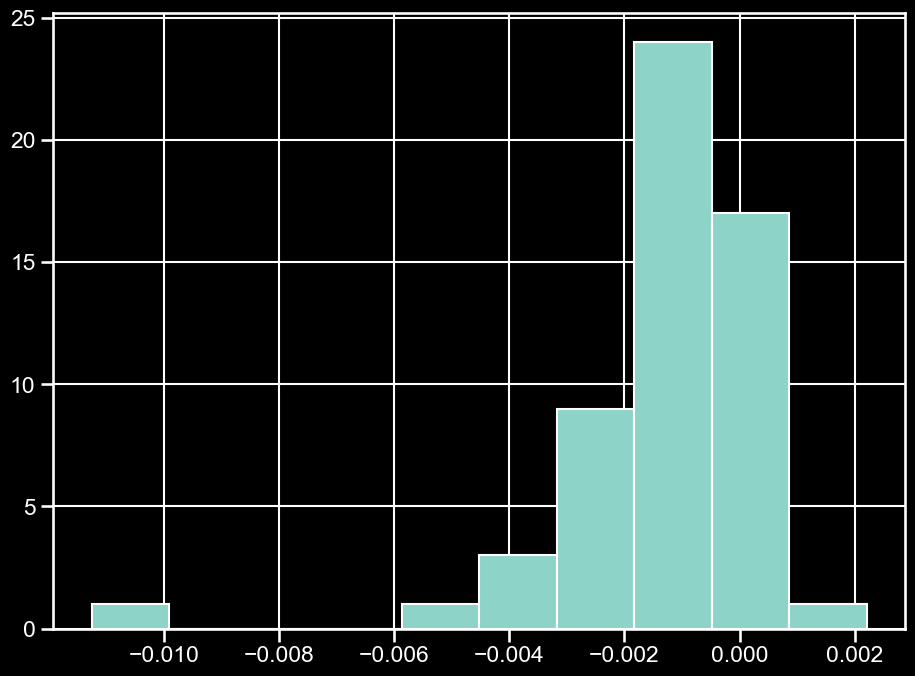

In [40]:
base_re_mrf.b_hat_history[-1][1].hist()

### Model - MERF with the Best Random Search Parameter 

In [41]:
rf_random.best_params_


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [42]:
cv = KFold(n_splits=5, shuffle=True)
mse_random_re_mrf = []
mape_random_re_mrf = []
error_random_re_mrf = []
accuracy_random_re_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    random_re_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=800,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 'auto',
                                                             max_depth= 100,
                                                             bootstrap= True))
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    random_re_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = random_re_mrf.predict(X_test, Z_test, clusters_test)
    mse_random_re_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_random_re_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_random_re_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_random_re_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_random_re_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_random_re_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_random_re_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_random_re_mrf)))

INFO     [merf.py:307] Training GLL is -3500.318568110332 at iteration 1.
INFO     [merf.py:307] Training GLL is -6263.312478331266 at iteration 2.
INFO     [merf.py:307] Training GLL is -8755.96830319278 at iteration 3.
INFO     [merf.py:307] Training GLL is -11125.124458044396 at iteration 4.
INFO     [merf.py:307] Training GLL is -13418.97792929107 at iteration 5.
INFO     [merf.py:307] Training GLL is -15644.90713638964 at iteration 6.
INFO     [merf.py:307] Training GLL is -17741.963663830782 at iteration 7.
INFO     [merf.py:307] Training GLL is -19469.42797841364 at iteration 8.
INFO     [merf.py:307] Training GLL is -20480.487058181745 at iteration 9.
INFO     [merf.py:307] Training GLL is -20886.291190868462 at iteration 10.
INFO     [merf.py:307] Training GLL is -21054.231916830133 at iteration 11.
INFO     [merf.py:307] Training GLL is -21144.365586685322 at iteration 12.
INFO     [merf.py:307] Training GLL is -21200.912653763116 at iteration 13.
INFO     [merf.py:307] Train

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 92.98%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 7.02%


<AxesSubplot: >

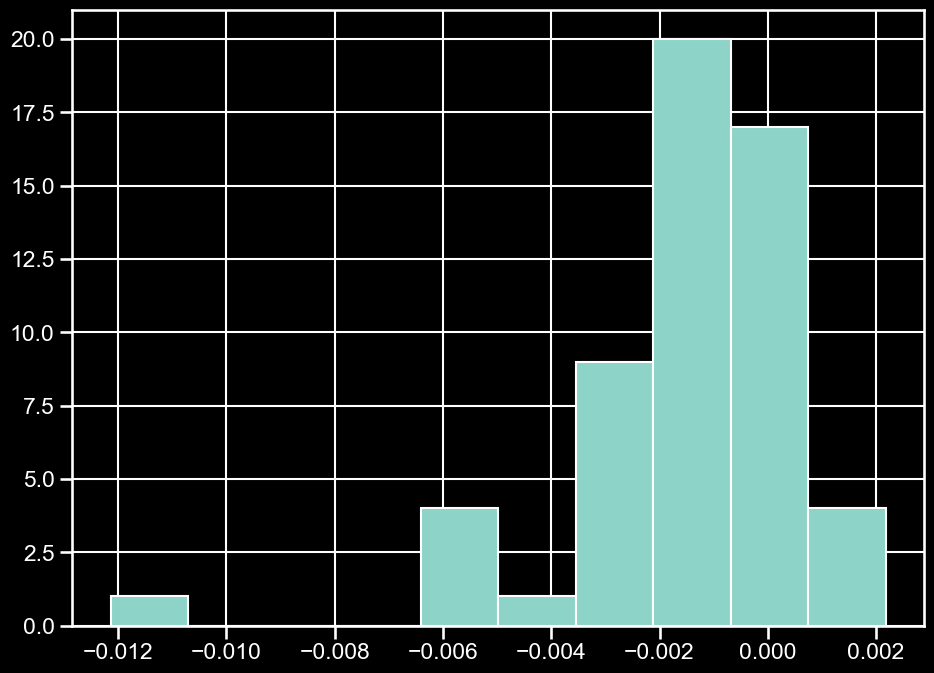

In [43]:
random_re_mrf.b_hat_history[-1][1].hist()

### Model - MERF with the Best Grid Search Parameter 

In [44]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [45]:
cv = KFold(n_splits=5, shuffle=True)
mse_grid_re_mrf = []
mape_grid_re_mrf = []
error_grid_re_mrf = []
accuracy_grid_re_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as RE
    grid_re_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=1000,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 3,
                                                             max_depth= 80,
                                                             bootstrap= True))
    X_train =  train[['Time']]
    Z_train = np.array((np.ones(len(X_train)), train['Renewable energy consumption'], 
                                               train['Trade (% of GDP)'],
                                               train['Perc Manufacturing Value Added'],
                                               train['GDP per capita'],
                                               train['Urban Population'])).T
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    grid_re_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as RE
    X_test =  test[['Time']]
    Z_test = np.array((np.ones(len(X_test)),test['Renewable energy consumption'], 
                                               test['Trade (% of GDP)'],
                                               test['Perc Manufacturing Value Added'],
                                               test['GDP per capita'],
                                               test['Urban Population'])).T
    clusters_test = test['Country']
    yhat_mrf = grid_re_mrf.predict(X_test, Z_test, clusters_test)
    mse_grid_re_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_grid_re_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_grid_re_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_grid_re_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_re_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_grid_re_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_grid_re_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_grid_re_mrf)))

INFO     [merf.py:307] Training GLL is -3499.59151047133 at iteration 1.
INFO     [merf.py:307] Training GLL is -6261.900473334591 at iteration 2.
INFO     [merf.py:307] Training GLL is -8755.036892843616 at iteration 3.
INFO     [merf.py:307] Training GLL is -11125.013653244065 at iteration 4.
INFO     [merf.py:307] Training GLL is -13417.129877815425 at iteration 5.
INFO     [merf.py:307] Training GLL is -15628.26825700073 at iteration 6.
INFO     [merf.py:307] Training GLL is -17660.1653257057 at iteration 7.
INFO     [merf.py:307] Training GLL is -19200.2575568347 at iteration 8.
INFO     [merf.py:307] Training GLL is -19979.416422660255 at iteration 9.
INFO     [merf.py:307] Training GLL is -20285.970555966498 at iteration 10.
INFO     [merf.py:307] Training GLL is -20433.96023184468 at iteration 11.
INFO     [merf.py:307] Training GLL is -20523.09274758091 at iteration 12.
INFO     [merf.py:307] Training GLL is -20583.111238938924 at iteration 13.
INFO     [merf.py:307] Training 

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 93.47%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 6.53%


<AxesSubplot: >

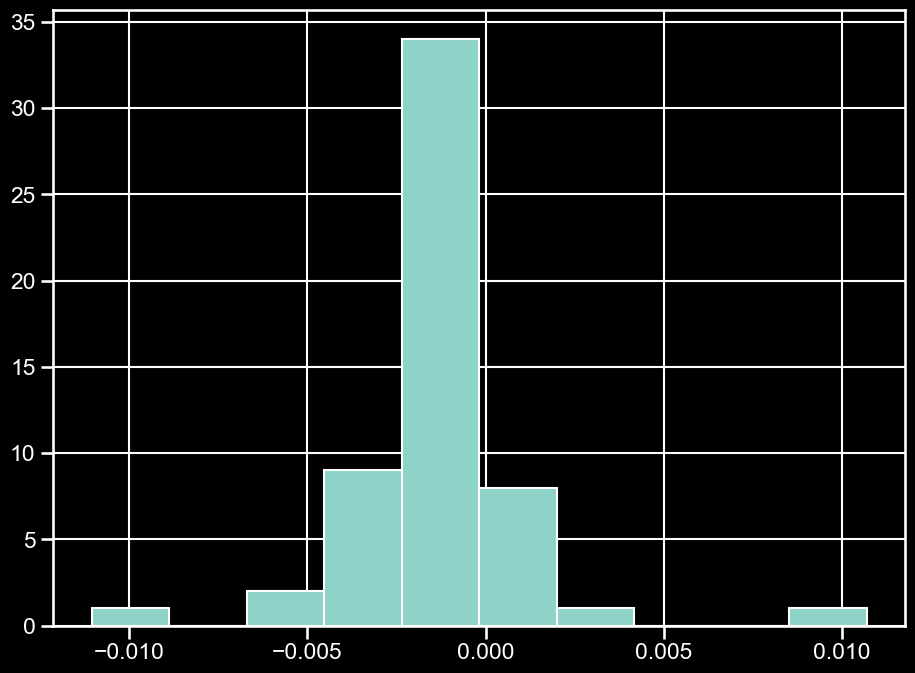

In [46]:
grid_re_mrf.b_hat_history[-1][1].hist()

## Predictor variable as Fixed Effect

### Base Model

In [47]:
cv = KFold(n_splits=5, shuffle=True)
mse_base_fe_mrf = []
mape_base_fe_mrf = []
error_base_fe_mrf = []
accuracy_base_fe_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as FE
    base_fe_mrf = MERF()
    X_train =  train[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    base_fe_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as FE
    X_test =  test[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = base_fe_mrf.predict(X_test, Z_test, clusters_test)
    mse_base_fe_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_base_fe_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_base_fe_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_base_fe_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_base_fe_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_base_fe_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_base_fe_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_base_fe_mrf)))

INFO     [merf.py:307] Training GLL is -3718.359777897217 at iteration 1.
INFO     [merf.py:307] Training GLL is -7436.69805508503 at iteration 2.
INFO     [merf.py:307] Training GLL is -11154.619404408148 at iteration 3.
INFO     [merf.py:307] Training GLL is -14861.728227804546 at iteration 4.
INFO     [merf.py:307] Training GLL is -18392.53460085926 at iteration 5.
INFO     [merf.py:307] Training GLL is -20092.644158373496 at iteration 6.
INFO     [merf.py:307] Training GLL is -20596.533388472304 at iteration 7.
INFO     [merf.py:307] Training GLL is -20275.47520717275 at iteration 8.
INFO     [merf.py:307] Training GLL is -20469.45977921884 at iteration 9.
INFO     [merf.py:307] Training GLL is -20472.64844923066 at iteration 10.
INFO     [merf.py:307] Training GLL is -20634.44246346996 at iteration 11.
INFO     [merf.py:307] Training GLL is -20366.502054378994 at iteration 12.
INFO     [merf.py:307] Training GLL is -20580.06496171536 at iteration 13.
INFO     [merf.py:307] Trainin

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 91.56%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 8.44%


<AxesSubplot: >

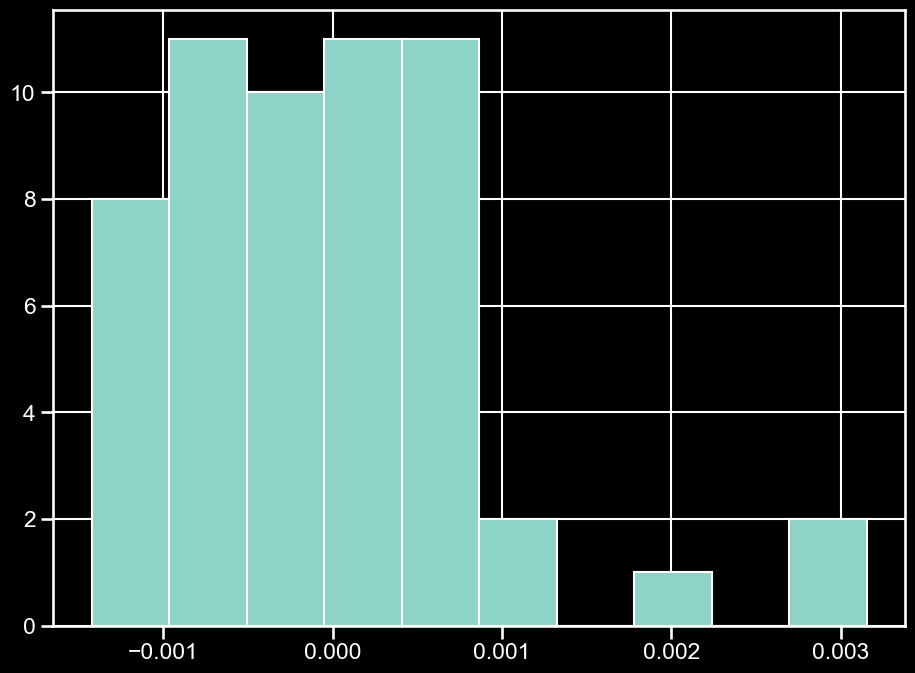

In [48]:
base_fe_mrf.b_hat_history[-1][0].hist()

### Model - MERF with the Best Random Search Parameter 

In [49]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [50]:
cv = KFold(n_splits=5, shuffle=True)
mse_random_fe_mrf = []
mape_random_fe_mrf = []
error_random_fe_mrf = []
accuracy_random_fe_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as FE
    random_fe_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=800,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 'auto',
                                                             max_depth= 100,
                                                             bootstrap= True))
    X_train =  train[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    random_fe_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as FE
    X_test =  test[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = random_fe_mrf.predict(X_test, Z_test, clusters_test)
    mse_random_fe_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_random_fe_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_random_fe_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_random_fe_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_random_fe_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_random_fe_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_random_fe_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_random_fe_mrf)))

INFO     [merf.py:307] Training GLL is -3718.3636499296244 at iteration 1.
INFO     [merf.py:307] Training GLL is -7436.6784013389315 at iteration 2.
INFO     [merf.py:307] Training GLL is -11154.104333212365 at iteration 3.
INFO     [merf.py:307] Training GLL is -14853.687058642865 at iteration 4.
INFO     [merf.py:307] Training GLL is -18173.394736110364 at iteration 5.
INFO     [merf.py:307] Training GLL is -19370.47961727788 at iteration 6.
INFO     [merf.py:307] Training GLL is -19507.674207969863 at iteration 7.
INFO     [merf.py:307] Training GLL is -19565.385585045413 at iteration 8.
INFO     [merf.py:307] Training GLL is -19496.107369360794 at iteration 9.
INFO     [merf.py:307] Training GLL is -19496.879026340495 at iteration 10.
INFO     [merf.py:307] Training GLL is -19470.08692351227 at iteration 11.
INFO     [merf.py:307] Training GLL is -19354.318920706315 at iteration 12.
INFO     [merf.py:307] Training GLL is -19411.867483709564 at iteration 13.
INFO     [merf.py:307] 

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 93.72%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 6.28%


In [51]:
base_fe_mrf

### Model - MERF with the Best Grid Search Parameter 

In [52]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [53]:
cv = KFold(n_splits=5, shuffle=True)
mse_grid_fe_mrf = []
mape_grid_fe_mrf = []
error_grid_fe_mrf = []
accuracy_grid_fe_mrf = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']

    # Mixed Effects Random Forest Training with 5 vaiables as FE
    grid_fe_mrf = MERF(fixed_effects_model=RandomForestRegressor(n_estimators=1000,
                                                             min_samples_split= 2,
                                                             min_samples_leaf= 1,
                                                             max_features= 3,
                                                             max_depth= 80,
                                                             bootstrap= True))
    X_train =  train[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    grid_fe_mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with 5 vaiables as FE
    X_test =  test[['Time',
                     'Renewable energy consumption',
                     'Trade (% of GDP)',
                     'Perc Manufacturing Value Added',
                     'GDP per capita',
                     'Urban Population']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = grid_fe_mrf.predict(X_test, Z_test, clusters_test)
    mse_grid_fe_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

    errors = abs(y - yhat_mrf)
    error_grid_fe_mrf.append(errors)    
    mape = 100 * np.mean(errors / yhat_mrf)
    mape_grid_fe_mrf.append(mape)
    accuracy = 100 - mape
    accuracy_grid_fe_mrf.append(accuracy)

print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_fe_mrf]))))
print('Accuracy: {:0.2f}%.'.format(np.mean(accuracy_grid_fe_mrf)))
print('MSE: {:0.2f}.'.format(np.mean(mse_grid_fe_mrf)))
print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(np.mean(mape_grid_fe_mrf)))

INFO     [merf.py:307] Training GLL is -3718.3588464668783 at iteration 1.
INFO     [merf.py:307] Training GLL is -7436.664130428352 at iteration 2.
INFO     [merf.py:307] Training GLL is -11153.925444389552 at iteration 3.
INFO     [merf.py:307] Training GLL is -14847.684865346011 at iteration 4.
INFO     [merf.py:307] Training GLL is -18123.760341078432 at iteration 5.
INFO     [merf.py:307] Training GLL is -19257.06806629658 at iteration 6.
INFO     [merf.py:307] Training GLL is -19159.594202612276 at iteration 7.
INFO     [merf.py:307] Training GLL is -19213.773990331894 at iteration 8.
INFO     [merf.py:307] Training GLL is -19301.96337404475 at iteration 9.
INFO     [merf.py:307] Training GLL is -19097.80944307711 at iteration 10.
INFO     [merf.py:307] Training GLL is -19290.061401676896 at iteration 11.
INFO     [merf.py:307] Training GLL is -19241.23675097058 at iteration 12.
INFO     [merf.py:307] Training GLL is -19312.17598169065 at iteration 13.
INFO     [merf.py:307] Trai

Model Performance
Average Error: 0.0002 degrees.
Accuracy: 94.25%.
MSE: 0.00.
Mean Absolute Percentage Error (MAPE): 5.75%


### Model Evaluation Metrics Summary

In [54]:
data = [['Random Forest (Base Model)', base_rf_errors,base_rf_accuracy,base_rf_mse,base_rf_mape],
['Random Forest (Best Random Search Model)',random_rf_errors,random_rf_accuracy,random_rf_mse,random_rf_mape],
['Random Forest (Best Grid Search Model)',grid_rf_errors,grid_rf_accuracy,grid_rf_mse,grid_rf_mape],
['MERF with Predictor Variable as RE (Base Model)', round(np.mean(np.mean([np.mean(error_set) for error_set in error_base_re_mrf])),6),round(np.mean(accuracy_base_re_mrf),1),round(np.mean(mse_base_re_mrf),6),round(np.mean(mape_base_re_mrf),2)],
['MERF with Predictor Variable as RE (Best Random Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_random_re_mrf])),6),round(np.mean(accuracy_random_re_mrf),2),round(np.mean(mse_random_re_mrf),6),round(np.mean(mape_random_re_mrf),2)],
['MERF with Predictor Variable as RE (Best Grid Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_re_mrf])),6),round(np.mean(accuracy_grid_re_mrf),2),round(np.mean(mse_grid_re_mrf),6),round(np.mean(mape_grid_re_mrf),2)],
['MERF with Predictor Variable as FE (Base Model)', round(np.mean(np.mean([np.mean(error_set) for error_set in error_base_fe_mrf])),6),round(np.mean(accuracy_base_fe_mrf),2),round(np.mean(mse_base_fe_mrf),6),round(np.mean(mape_base_fe_mrf),2)],
['MERF with Predictor Variable as FE (Best Random Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_random_fe_mrf])),6),round(np.mean(accuracy_random_fe_mrf),2),round(np.mean(mse_random_fe_mrf),6),round(np.mean(mape_random_fe_mrf),2)],
['MERF with Predictor Variable as FE (Best Grid Search Model)',round(np.mean(np.mean([np.mean(error_set) for error_set in error_grid_fe_mrf])),6),round(np.mean(accuracy_grid_fe_mrf),2),round(np.mean(mse_grid_fe_mrf),6),round(np.mean(mape_grid_fe_mrf),2)]]

In [55]:
results = pd.DataFrame(data = data, columns=['Model',
                                'Average Error',
                                'Accuracy', 
                                'Mean Squared Error (MSE)',
                                'Mean Absolute Percentage Error (MAPE)'])

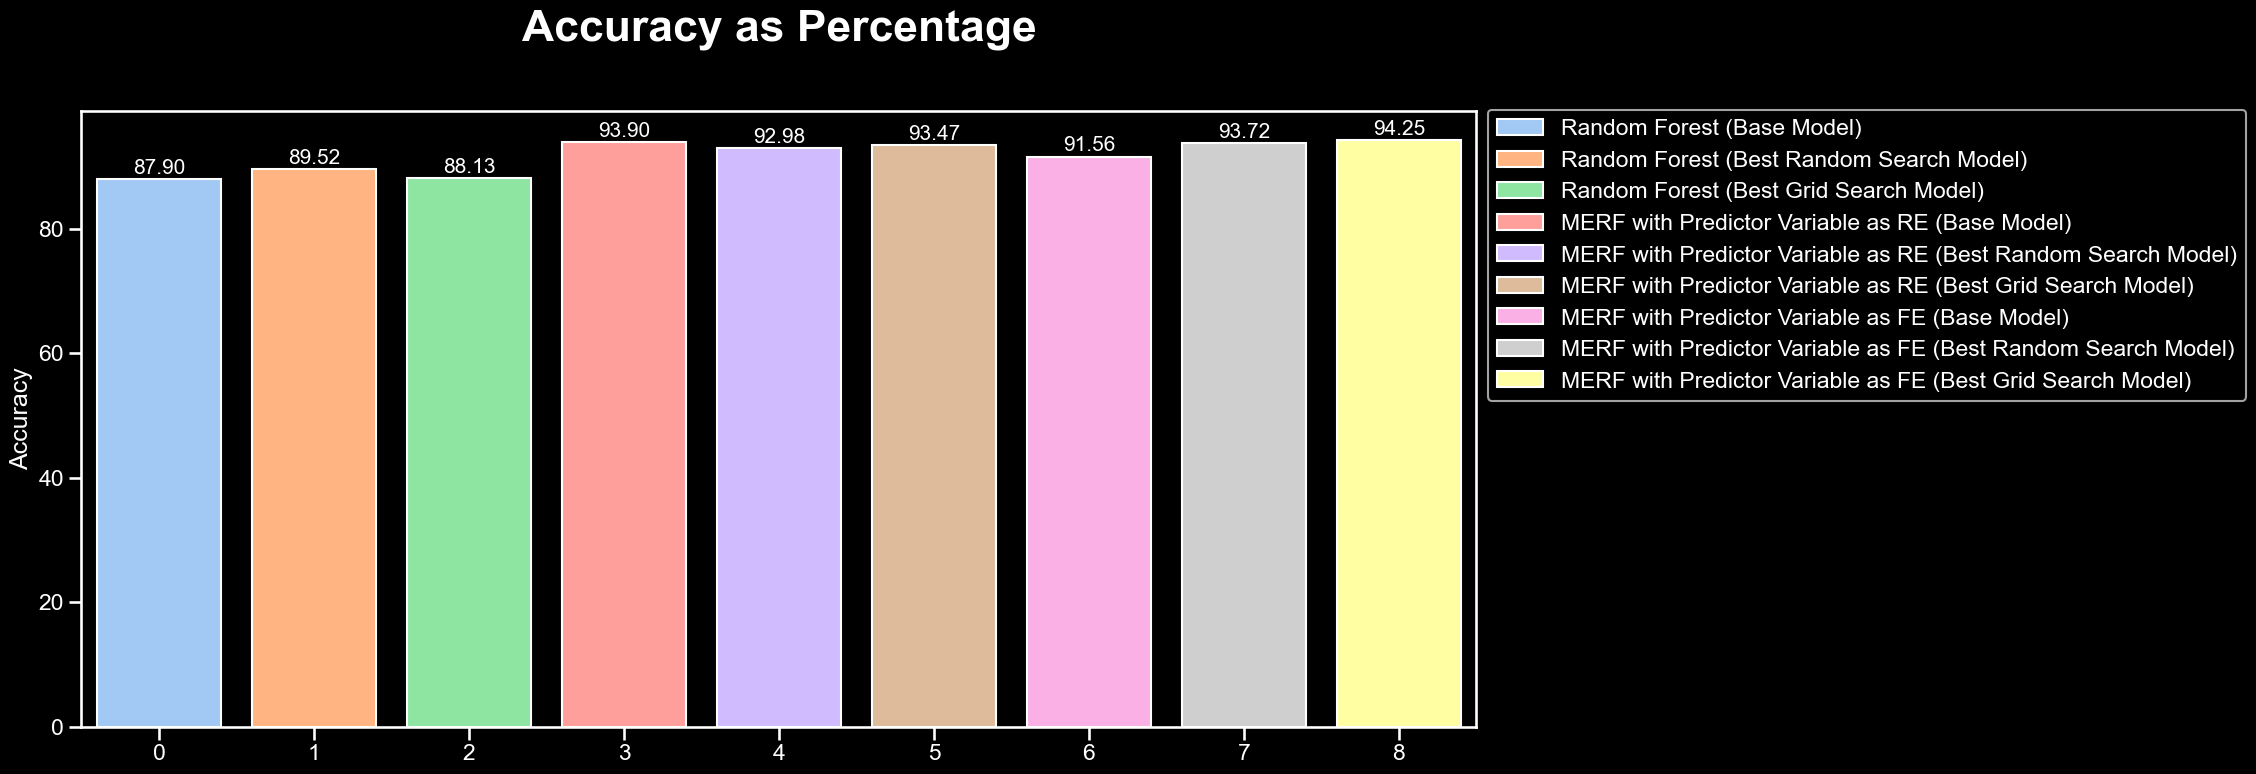

In [56]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Accuracy', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Accuracy as Percentage",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
   
  ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


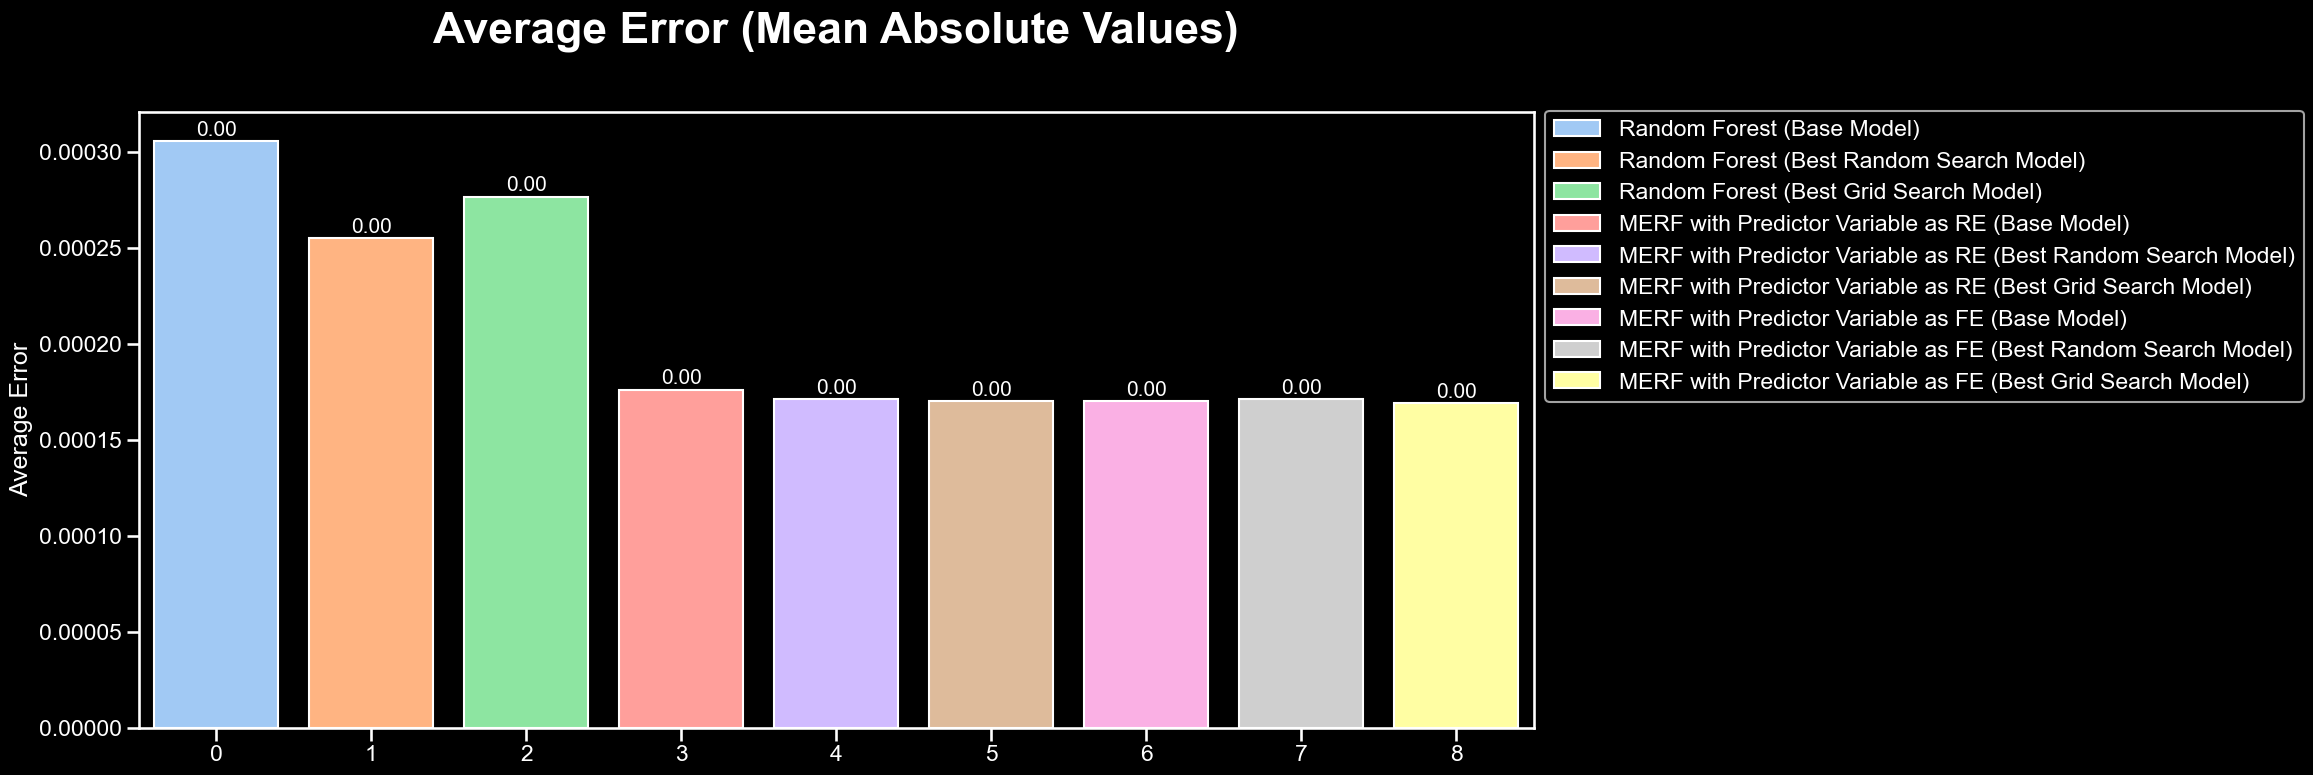

In [57]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Average Error', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Average Error (Mean Absolute Values)",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
   
  ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


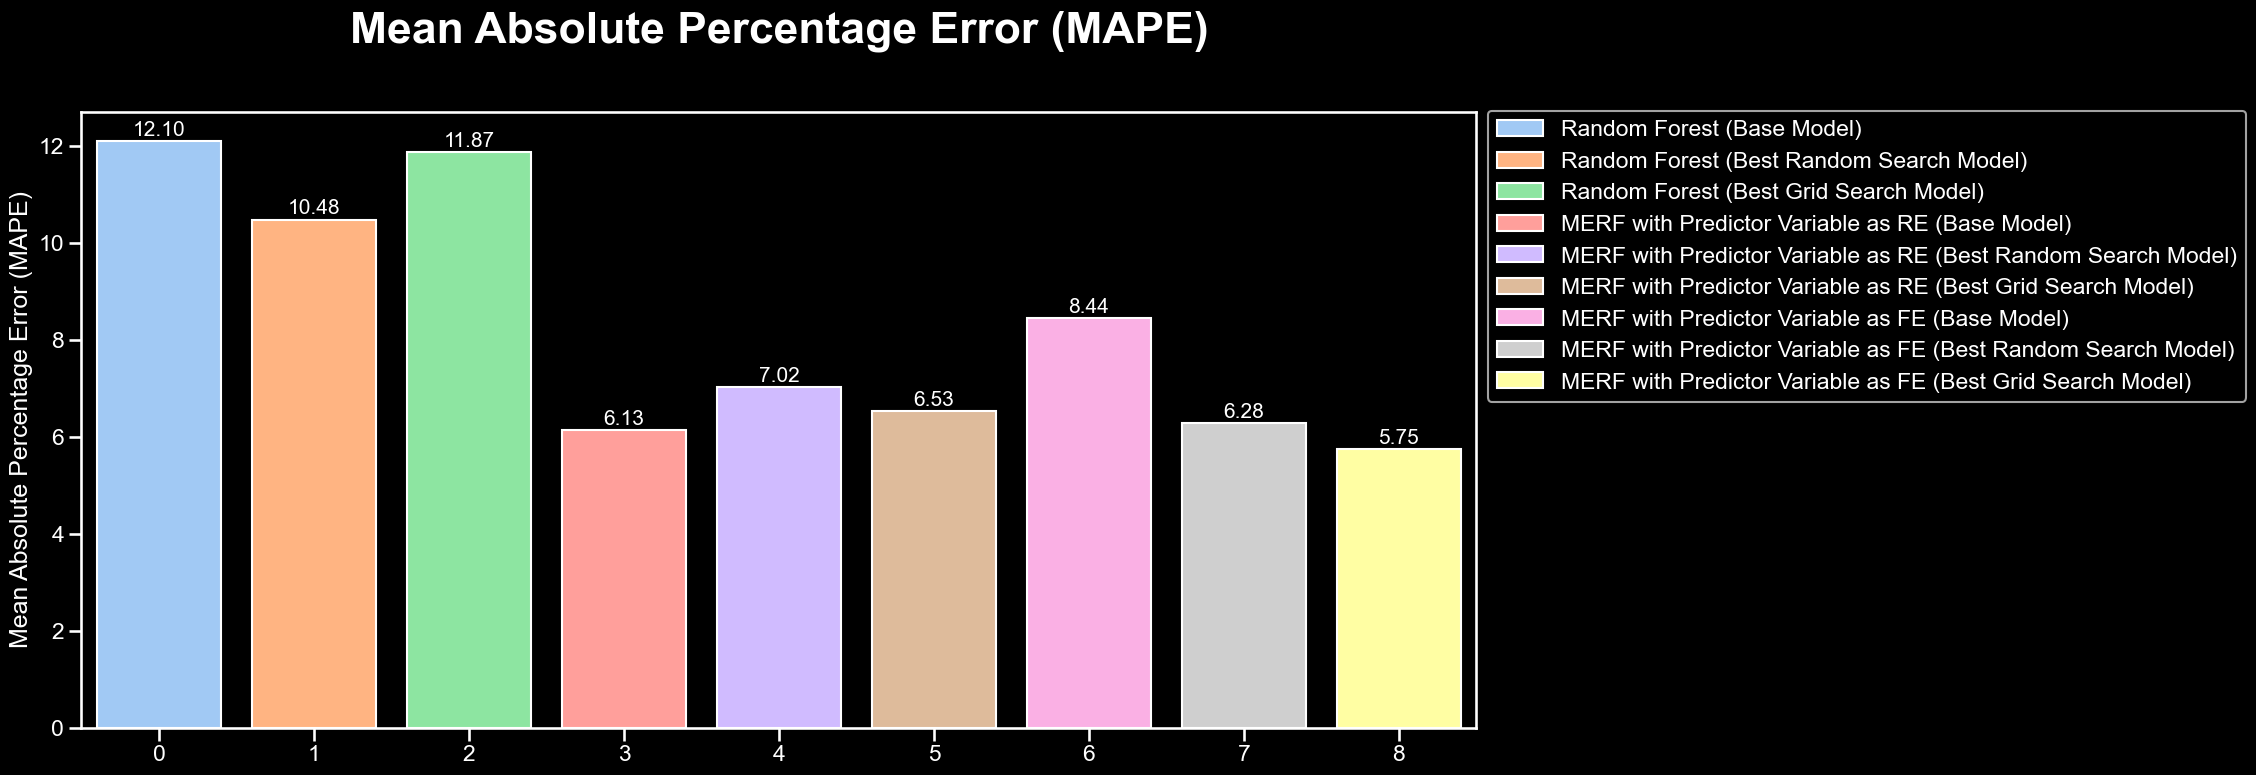

In [58]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Mean Absolute Percentage Error (MAPE)', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Mean Absolute Percentage Error (MAPE)",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
   
  ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


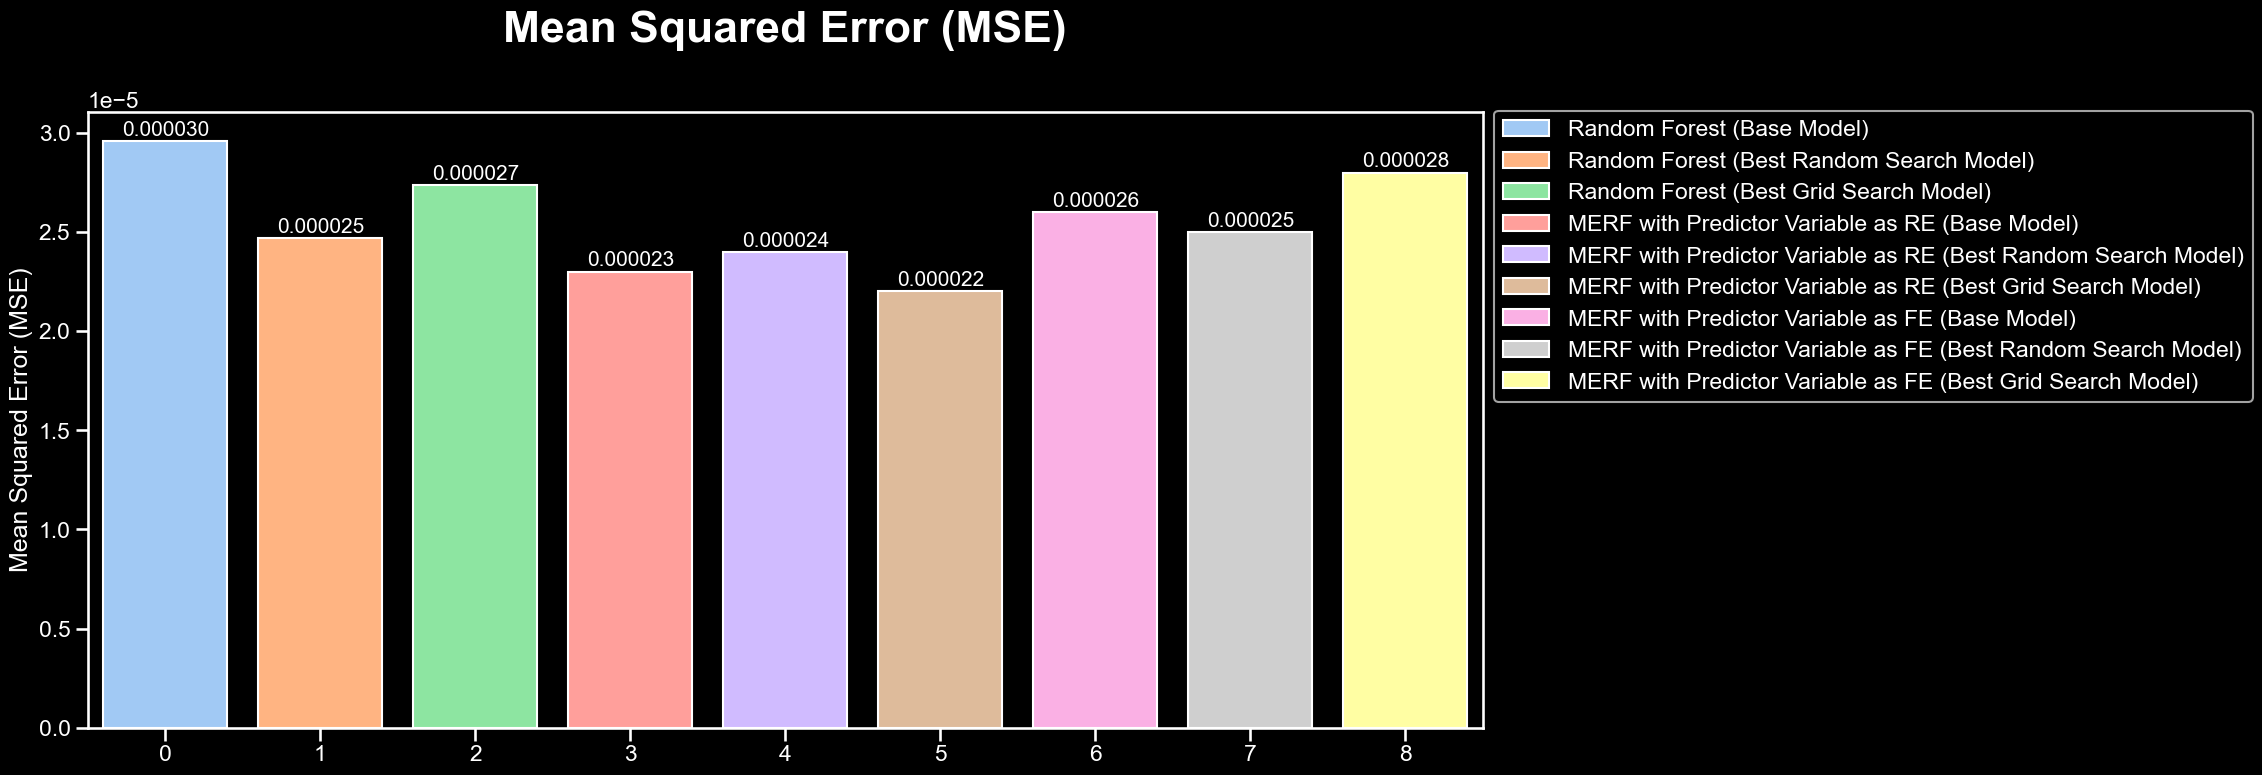

In [59]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x = results.index, y = 'Mean Squared Error (MSE)', data = results,hue = 'Model',
            palette = 'pastel',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'black', errwidth = 1,  
            ci = 'sd',
            dodge = False
            )

ax.legend(bbox_to_anchor=(1, 1.02))
ax.set_title("Mean Squared Error (MSE)",fontdict= { 'fontsize': 32,'fontweight':'bold'}, y = 1.1)
for bar in ax.patches:
   
  ax.annotate(format(bar.get_height(), '.6f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

